# Steady-State: Optomechanical System in the Single-Photon Strong-Coupling Regime

P.D. Nation and J.R. Johansson

For more information about QuTiP see [http://qutip.org](http://qutip.org)

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
from qutip import (about, destroy, hinton, ptrace, qdiags, qeye, steadystate,
                   tensor, wigner, wigner_cmap, basis, fidelity, mesolve)

%matplotlib inline

## Optomechanical Hamiltonian

The optomechanical Hamiltonian arises from the radiation pressure interaction of light in an optical cavity where one of the cavity mirrors is mechanically compliant.

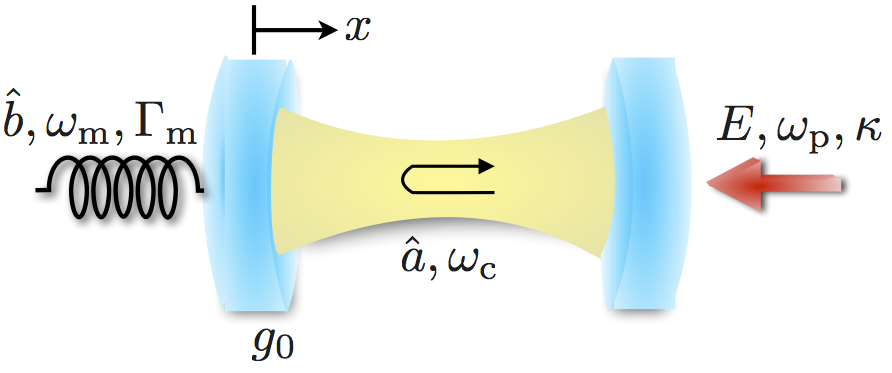

In [2]:
Image(filename="images/optomechanical_setup.png", width=500, embed=True)

Assuming that $a^{+}$, $a$ and $b^{+}$,$b$ are the raising and lowering operators for the cavity and mechanical oscillator, respectively, the Hamiltonian for an optomechanical system driven by a classical monochromatic pump term can be written as 

\begin{equation}
\frac{\hat{H}}{\hbar}=-\Delta\hat{a}^{+}\hat{a}+\omega_{m}\hat{b}^{+}\hat{b}+g_{0}(\hat{b}+\hat{b}^{+})\hat{a}^{+}\hat{a}+E\left(\hat{a}+\hat{a}^{+}\right),
\end{equation}

where $\Delta=\omega_{p}-\omega_{c}$ is the detuning between the pump ($\omega_{p}$) and cavity ($\omega_{c}$) mode frequencies, $g_{0}$ is the single-photon coupling strength, and $E$ is the amplitude of the pump mode. It is known that in the single-photon strong-coupling regime, where the cavity frequency shift per phonon is larger than the cavity line width, $g_{0}/\kappa \gtrsim 1$ where $\kappa$ is the decay rate of the cavity, and a single single photon displaces the mechanical oscillator by more than its zero-point amplitude $g_{0}/\omega_{m} \gtrsim 1$, or equiviently, $g^{2}_{0}/\kappa\omega_{m} \gtrsim 1$, the mechanical oscillator can be driven into a nonclassical steady state of the system$+$environment dynamics.  Here, we will use the steady state solvers in QuTiP to explore such a state and compare the various solvers.

## Solving for the Steady State Density Matrix

The steady state density matrix of the optomechanical system plus the environment can be found from the Liouvillian superoperator $\mathcal{L}$ via

\begin{equation}
\frac{d\rho}{dt}=\mathcal{L}\rho=0\rho,
\end{equation}

where $\mathcal{L}$ is typically given in Lindblad form
\begin{align}
\mathcal{L}[\hat{\rho}]=&-i[\hat{H},\hat{\rho}]+\kappa \mathcal{D}\left[\hat{a},\hat{\rho}\right]\\
&+\Gamma_{m}(1+n_{\rm{th}})\mathcal{D}[\hat{b},\hat{\rho}]+\Gamma_{m}n_{\rm th}\mathcal{D}[\hat{b}^{+},\hat{\rho}], \nonumber
\end{align}

where $\Gamma_{m}$ is the coulping strength of the mechanical oscillator to its thermal environment with average occupation number $n_{th}$.  As is customary, here we assume that the cavity mode is coupled to the vacuum.

Although, the steady state solution is nothing but an eigenvalue equation, the numerical solution to this equation is anything but trivial due to the non-Hermitian structure of $\mathcal{L}$ and its worsening condition number as the dimensionality of the truncated Hilbert space increases.

## Steady State Solvers in QuTiP v5.0+

As of QuTiP version 5.0, the following steady state solving methods are available:

- **direct**: Direct LU factorization
- **eigen**: Calculates the eigenvector associated with the zero eigenvalue of $\mathcal{L}\rho$.
- **svd**: Solution via SVD decomposition (dense matrices only).
- **power**: Finds zero eigenvector using inverse-power method.

Among these, when using `direct` and `power` methods one can use the following ``solvers`` for the factorization:

- **Dense solvers**: from ``numpy.linalg``.
    - solve - exact solution via LAPACK routine ``_gesv``.
    - lstsq - best least-squares solution by minimizing the L2-norm.
- **Sparse solvers**: sparse solvers from ``scipy.sparse.linalg``
    - spsolve - Exact solution via UMFPACK.
    - gmres - Iterative solution via the GMRES solver.
    - lgmres - Iterative solution via the LGMRES solver.
    - bicgstab - Iterative solution via the BICGSTAB solver.
- **MKL solver**: a sparse solver by ``mkl``
    - mkl_spsolve - solution via Intel's MKL Pardiso solver.

## Setup and Solution

### System Parameters

In [3]:
# System Parameters (in units of wm)
# -----------------------------------
Nc = 4  # Number of cavity states
Nm = 12  # Number of mech states
kappa = 0.3  # Cavity damping rate
E = 0.1  # Driving Amplitude
g0 = 2.4 * kappa  # Coupling strength
Qm = 0.3 * 1e4  # Mech quality factor
gamma = 1 / Qm  # Mech damping rate
n_th = 1  # Mech bath temperature
delta = -0.43  # Detuning

### Build Hamiltonian and Collapse Operators

In [4]:
# Operators
# ----------
a = tensor(destroy(Nc), qeye(Nm))
b = tensor(qeye(Nc), destroy(Nm))
num_b = b.dag() * b
num_a = a.dag() * a

# Hamiltonian
# ------------
H = -delta * (num_a) + num_b + g0 * (b.dag() + b) * num_a + E * (a.dag() + a)

# Collapse operators
# -------------------
cc = np.sqrt(kappa) * a
cm = np.sqrt(gamma * (1.0 + n_th)) * b
cp = np.sqrt(gamma * n_th) * b.dag()
c_ops = [cc, cm, cp]

### Run Steady State Solvers

In [5]:
# all possible methods
possible_methods = ["direct", "eigen", "svd", "power"]

# all possible solvers for direct (and power) method(s)
possible_solvers = [
    "solve",
    "lstsq",
    "spsolve",
    "gmres",
    "lgmres",
    "bicgstab",
    "mkl_spsolve",
]

# method and solvers used here
method = "direct"
solvers = ["spsolve", "gmres"]

mech_dms = []
for solver in solvers:
    if solver in ["gmres", "bicgstab"]:
        precond_options = {
            "permc_spec": "NATURAL",
            "diag_pivot_thresh": 0.1,
            "fill_factor": 100,
            "options": {"ILU_MILU": "smilu_2"},
        }
        solver_options = {
            "use_precond": True,
            "atol": 1e-15,
            "maxiter": int(1e5),
            **precond_options,
        }
        use_rcm = True
    else:
        solver_options = {}
        use_rcm = False

    start = time.time()
    rho_ss = steadystate(
        H,
        c_ops,
        method=method,
        solver=solver,
        use_rcm=use_rcm,
        **solver_options,
    )
    end = time.time()

    print(f"Solver: {solver}, Time: {np.round(end-start, 5)}")
    rho_mech = ptrace(rho_ss, 1)
    mech_dms.append(rho_mech)

rho_mech = mech_dms[0]
mech_dms = [mech_dm.data.as_ndarray() for mech_dm in mech_dms]

Solver: spsolve, Time: 0.1322
Solver: gmres, Time: 0.16832


### Check Consistency of Solutions

Can check to see if the solutions are the same by looking at the number of nonzero elements (NNZ) in the difference between mechanical density matrices.

In [6]:
for kk in range(len(mech_dms)):
    c = np.where(
            np.abs(mech_dms[kk].flatten() - mech_dms[0].flatten()) > 1e-5
        )[0]
    print(f"#NNZ for k = {kk} : {len(c)}")

#NNZ for k = 0 : 0
#NNZ for k = 1 : 0


## Plot the Mechanical Oscillator Wigner Function

It is known that the density matrix for the mechanical oscillator is diagonal in the Fock basis due to phase diffusion. If we look at the `hinton()` plot of the density matrix, we can see the magnitude of the diagonal elements is higher, such that the non-diagonal have a vanishing importance.

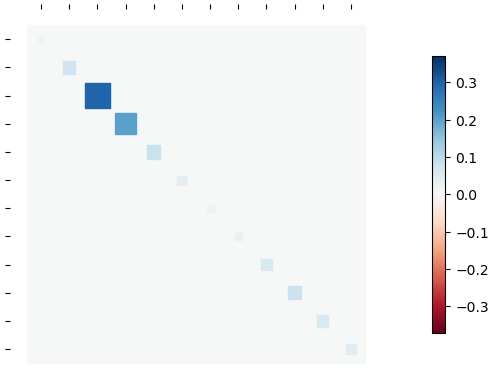

In [7]:
hinton(rho_mech.data.as_ndarray(), x_basis=[""] * Nm, y_basis=[""] * Nm);

However some small off-diagonal terms show up during the factorization process, which we can display by the using `plt.spy()`.

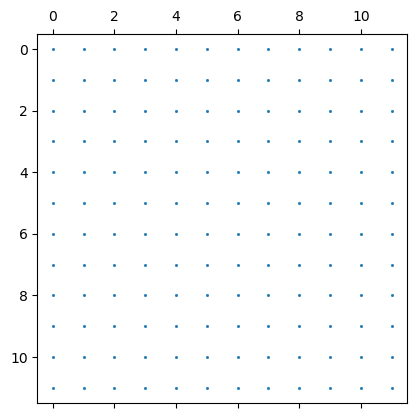

In [8]:
plt.spy(rho_mech.data.as_ndarray(), markersize=1);

Therefore, to remove this error, let use explicitly take the diagonal elements and form a new operator out of them.

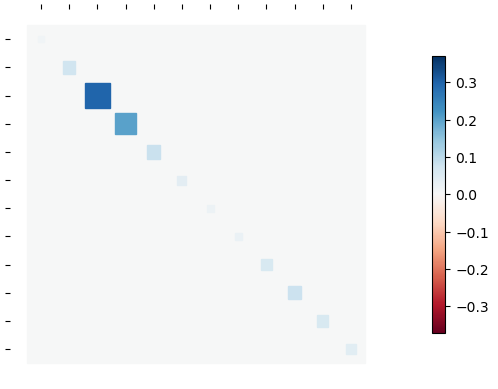

In [9]:
diag = rho_mech.diag()
rho_mech2 = qdiags(diag, 0, dims=rho_mech.dims, shape=rho_mech.shape)
hinton(rho_mech2, x_basis=[""] * Nm, y_basis=[""] * Nm);

Now lets compute the oscillator Wigner function and plot it to see if there are any regions of negativity.

In [10]:
xvec = np.linspace(-20, 20, 256)
W = wigner(rho_mech2, xvec, xvec)
wmap = wigner_cmap(W, shift=-1e-5)

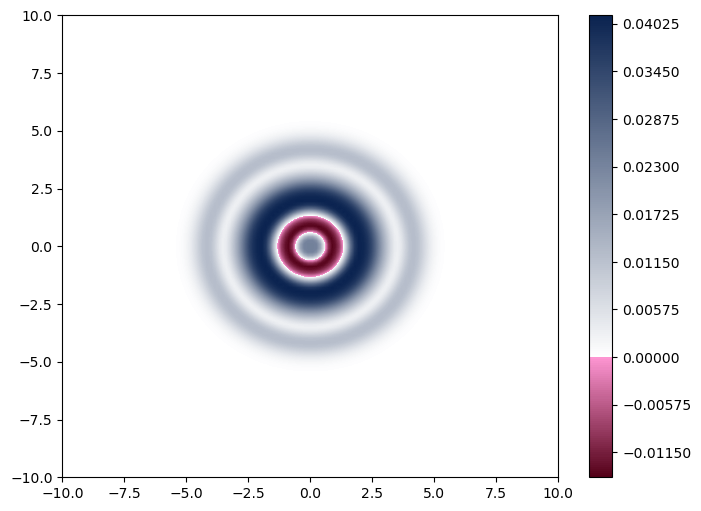

In [11]:
fig, ax = plt.subplots(figsize=(8, 6))
c = ax.contourf(xvec, xvec, W, 256, cmap=wmap)
ax.set_xlim([-10, 10])
ax.set_ylim([-10, 10])
plt.colorbar(c, ax=ax);

## About

In [12]:
about()


QuTiP: Quantum Toolbox in Python
Copyright (c) QuTiP team 2011 and later.
Current admin team: Alexander Pitchford, Nathan Shammah, Shahnawaz Ahmed, Neill Lambert, Eric Giguère, Boxi Li, Simon Cross, Asier Galicia, Paul Menczel, and Patrick Hopf.
Board members: Daniel Burgarth, Robert Johansson, Anton F. Kockum, Franco Nori and Will Zeng.
Original developers: R. J. Johansson & P. D. Nation.
Previous lead developers: Chris Granade & A. Grimsmo.
Currently developed through wide collaboration. See https://github.com/qutip for details.

QuTiP Version:      5.3.0.dev0+6e4b53d
Numpy Version:      2.3.5
Scipy Version:      1.16.3
Cython Version:     3.2.2
Matplotlib Version: 3.10.8
Python Version:     3.12.0
Number of CPUs:     4
BLAS Info:          blas
INTEL MKL Ext:      None
Platform Info:      Linux (x86_64)
Installation path:  /home/runner/miniconda3/envs/test-environment-v5/lib/python3.12/site-packages/qutip

Installed QuTiP family packages
-------------------------------

qutip-qtrl: 

qutip-jax: 0.1.1.dev6
qutip-qip: 0.5.0.dev0+81a92b9

Please cite QuTiP in your publication.
For your convenience a bibtex reference can be easily generated using `qutip.cite()`


## Testing

In [13]:
# assert obtained steady-state via mesolve evolution
psi0 = tensor(basis(Nc), basis(Nm))
rho0 = psi0 @ psi0.dag()
tlist = np.linspace(0, 1500, 1500)
rho_evolve = mesolve(H, rho0, tlist, c_ops)
rho_final = ptrace(rho_evolve.states[-1], 1)
assert fidelity(rho_mech, rho_final) > 0.99

# assert steady-state is diagonally dominant
rho_mat = np.abs(rho_mech.data.to_array())
assert np.all(2 * np.diag(rho_mat) >= np.sum(rho_mat, axis=1))

# assert for negativity in the Wigner function
assert np.any(W < 0)